# Evasion Attacks - Part 2


### References
[1] https://arxiv.org/pdf/1608.04644.pdf

[2] ART Example https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/get_started_pytorch.py

## Task
Reproduce the attack in Carlini and Wagner's paper [1]:
- Use their three different attack metrics: L0, L2, Linf 
- Reproduce their network architecture (including hyperparameters)
- Attack the first image of each class with a targeted attack to predict any class from it (as in the paper). 
- Expected result: The plot matrix as in Figs. 3-5 in [1].


In [141]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt 


In [142]:
from art.attacks.evasion import CarliniL0Method, CarliniL2Method, CarliniLInfMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

In [160]:

# Step 0: Define the neural network model, return logits instead of activation in forward method

# NO DROPOUT 

class myNet(nn.Module):
    def __init__(self):
        super(myNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(4096, 200)
        self.fc2 = nn.Linear(200, 200)
        
        self.fc3 = nn.Linear(200, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = x.view(-1, 64 * 8 * 8)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = F.softmax(self.fc3(x), dim=1)
        
        return x

In [167]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.pool1(self.relu(self.conv2(self.relu(self.conv1(x)))))
        x = self.pool2(self.relu(self.conv4(self.relu(self.conv3(x)))))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

model = Net()



### MNIST Dataset 

In [168]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)


### Define the Model 

In [169]:
model = Net()

# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

#### Wrap an art classifier around it

In [170]:
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

BATCH_SIZE = 128
classifier.fit(x_train, y_train, batch_size=BATCH_SIZE, nb_epochs=50)

KeyboardInterrupt: 

### Evaluation


__Benign examples__

In [69]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))



Accuracy on benign test examples: 97.74000000000001%


#### Create adversarial examples


#### Select Data 
- First image of each class


In [104]:
test_images = [None for i in range(10)]

test_images = x_train[:10]

### Targeted Attacks
Conduct targeted attack against the 10 images. Try to manipulate to any class.


In [136]:
from art.attacks.evasion import CarliniL0Method
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import CarliniLInfMethod

attack_L0 = CarliniL0Method(classifier=classifier, confidence=0.8, targeted=False, learning_rate=0.2)
x_test_adv_l0 = attack_L0.generate(x=test_images)

adv_predictions_l0 = classifier.predict(x_test_adv_l0)
adv_accuracy_l0 = np.sum(np.argmax(adv_predictions_l0, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(adv_accuracy_l0 * 100))

Accuracy on adversarial test examples: 0.0%


/tmp/ipykernel_8157/97115420.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  adv_accuracy_l0 = np.sum(np.argmax(adv_predictions_l0, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)


In [137]:
attack_L2 = CarliniL2Method(classifier=classifier, confidence=0.8, targeted=False, learning_rate=0.2)
x_test_adv_l2 = attack_L2.generate(x=test_images)

adv_predictions_l2 = classifier.predict(x_test_adv_l2)
adv_accuracy_l2 = np.sum(np.argmax(adv_predictions_l2, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(adv_accuracy_l2 * 100))

C&W L_2:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 0.0%


/tmp/ipykernel_8157/3232377492.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  adv_accuracy_l2 = np.sum(np.argmax(adv_predictions_l2, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)


In [138]:
attack_Linf = CarliniL2Method(classifier=classifier, confidence=0.8, targeted=False, learning_rate=0.2)
x_test_adv_linf = attack_Linf.generate(x=test_images)

adv_predictions_linf = classifier.predict(x_test_adv_linf)
adv_accuracy_linf = np.sum(np.argmax(adv_predictions_linf, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(adv_accuracy_linf * 100))

C&W L_2:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 0.0%


/tmp/ipykernel_8157/2317416526.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  adv_accuracy_linf = np.sum(np.argmax(adv_predictions_linf, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)


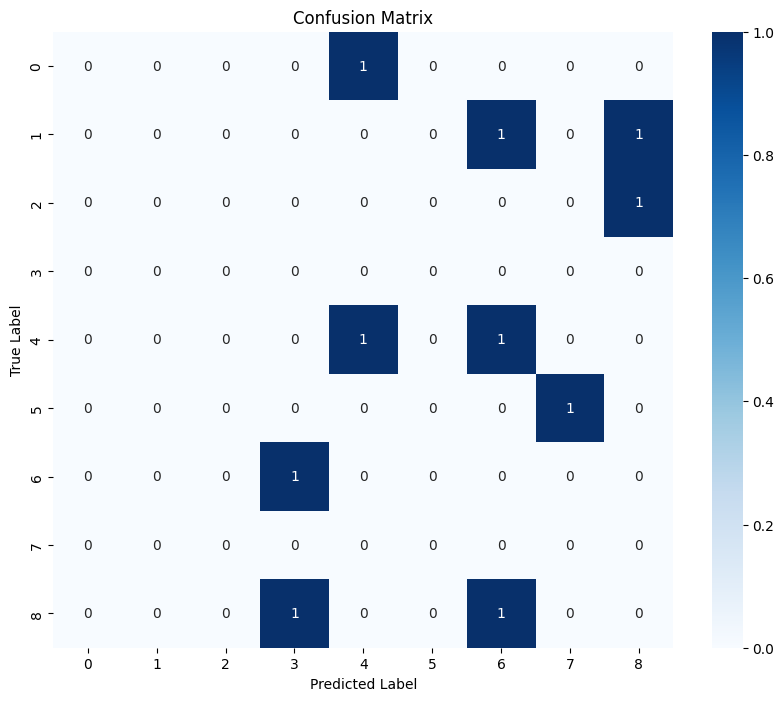

In [140]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(np.argmax(y_test[:10], axis=1), np.argmax(adv_predictions_l2, axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [147]:

# TODO - For reusability define a method that runs the attack against the test_images. Create the plot according to the figures in [1] also within this method.
def targeted_attack_cw_paper(attack):
    plt.clf()
    fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})

    attack_L0 = CarliniL0Method(classifier=classifier, confidence=0.8, targeted=False, learning_rate=0.2)
    adv_attack = attack_L0.generate(x=test_images)

    adv_predictions = classifier.predict(adv_attack)



    plt.show()

